# Aim : To predict clusters of customers by store location

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
from datetime import datetime
from sklearn.decomposition import PCA,KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')

In [2]:
#pd.set_option('display.max_rows',100)
#Product file contains products transaction information and highlights the discounts used by customers in each transaction.
prods=pd.read_csv('./data/cproducts.csv',header='infer',sep=',',delimiter=None,index_col=None,dtype=None)
#Tender file contains information on payment mode(s) used by a customer in making a transaction
tender=pd.read_csv('./data/ctender.csv',header='infer',sep=',',delimiter=None,index_col=None,dtype=None)

In [3]:
prods.shape

(11972, 16)

In [4]:
prods.columns

Index(['customerID', 'DOB', 'Gender', 'State', 'PinCode', 'transactionDate',
       'store_code', 'store_description', 'till_no',
       'transaction_number_by_till', 'promo_code', 'promotion_description',
       'product_code', 'product_description', 'sale_price_after_promo',
       'discountUsed'],
      dtype='object')

In [5]:
prods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 16 columns):
customerID                    11972 non-null object
DOB                           11653 non-null object
Gender                        10944 non-null object
State                         10389 non-null object
PinCode                       11155 non-null float64
transactionDate               11972 non-null object
store_code                    11972 non-null int64
store_description             11972 non-null object
till_no                       11972 non-null int64
transaction_number_by_till    11972 non-null int64
promo_code                    11972 non-null object
promotion_description         3462 non-null object
product_code                  11972 non-null int64
product_description           11972 non-null object
sale_price_after_promo        11972 non-null float64
discountUsed                  11972 non-null object
dtypes: float64(2), int64(4), object(10)
memory usage: 1.5+ MB

In [6]:
# check nulls
print('Columns With Nulls')
prods.isnull().sum() 

Columns With Nulls


customerID                       0
DOB                            319
Gender                        1028
State                         1583
PinCode                        817
transactionDate                  0
store_code                       0
store_description                0
till_no                          0
transaction_number_by_till       0
promo_code                       0
promotion_description         8510
product_code                     0
product_description              0
sale_price_after_promo           0
discountUsed                     0
dtype: int64

In [7]:
tender.shape

(149752, 13)

In [8]:
tender.columns

Index(['customerID', 'DOB', 'Gender', 'State', 'PinCode', 'transactionDate',
       'store_code', 'store_description', 'till_no', 'tender_type',
       'transaction_number_by_till', 'payment_amount_by_tender',
       'PaymentUsed'],
      dtype='object')

In [9]:
tender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149752 entries, 0 to 149751
Data columns (total 13 columns):
customerID                    149752 non-null object
DOB                           145156 non-null object
Gender                        143089 non-null object
State                         138102 non-null object
PinCode                       144188 non-null float64
transactionDate               149752 non-null object
store_code                    149752 non-null int64
store_description             149752 non-null object
till_no                       149752 non-null int64
tender_type                   149752 non-null object
transaction_number_by_till    149752 non-null int64
payment_amount_by_tender      149752 non-null float64
PaymentUsed                   148529 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 14.9+ MB


In [10]:
# check nulls
print('Columns With Nulls')
tender.isnull().sum()

Columns With Nulls


customerID                        0
DOB                            4596
Gender                         6663
State                         11650
PinCode                        5564
transactionDate                   0
store_code                        0
store_description                 0
till_no                           0
tender_type                       0
transaction_number_by_till        0
payment_amount_by_tender          0
PaymentUsed                    1223
dtype: int64

In [11]:
#df_prods= prods[['customerID', 'DOB', 'Gender', 'State', 'PinCode', 'transactionDate','store_code', 'store_description', 'till_no','transaction_number_by_till', 'promo_code', 'promotion_description','product_code', 'product_description', 'sale_price_after_promo','discountUsed']]
#df_tender= tender[['customerID', 'DOB', 'Gender', 'State', 'PinCode', 'transactionDate','store_code', 'store_description', 'till_no', 'tender_type','transaction_number_by_till', 'payment_amount_by_tender','PaymentUsed']]
df=pd.merge(prods,tender,on=['customerID', 'DOB', 'Gender', 'State', 'PinCode', 'transactionDate','store_code', 'store_description','transaction_number_by_till', ],how='inner')
df.drop(['till_no_x'],axis=1,inplace=True)
df.drop(['till_no_y'],axis=1,inplace=True)

In [12]:
print(df.shape)

(14466, 18)


In [13]:
df.head(3)

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed,tender_type,payment_amount_by_tender,PaymentUsed
0,BBID_20482,1975-10-20,male,MADHYA PRADESH,453441.0,2016-05-01,2655,BB-INDORE-MALHAR MEGA MALL,85246,NONPROMO,NaN,1000446431,PATANJALI CHOCOS 125g,55.00,Payback,EDCUBI,65.00,UBI CREDIT CARD
1,BBID_20498,1981-03-19,female,MAHARASHTRA,400064.0,2015-08-12,2655,BB-INDORE-MALHAR MEGA MALL,1064,0000971754,AD 399 FLAT LADIES JEANS FASHION EXC,1000077851005,"DLJ-0010-BSF-2-CJ-FL, 34, BLACK",418.95,Payback,CASH,768.45,CASH
2,BBID_20499,1986-05-10,male,MAHARASHTRA,400099.0,2016-12-18,2615,BB-AMRITSAR-TRILIUM MALL,51080,NONPROMO,NaN,1000443231,PATANJALI TOMATO KETCHUP BT 500g,70.00,Payback,MOBI,1701.24,One MobiKwik Systems


In [14]:
#df=df.dropna()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14466 entries, 0 to 14465
Data columns (total 18 columns):
customerID                    14466 non-null object
DOB                           13857 non-null object
Gender                        13646 non-null object
State                         13533 non-null object
PinCode                       13742 non-null float64
transactionDate               14466 non-null object
store_code                    14466 non-null int64
store_description             14466 non-null object
transaction_number_by_till    14466 non-null int64
promo_code                    14466 non-null object
promotion_description         4211 non-null object
product_code                  14466 non-null int64
product_description           14466 non-null object
sale_price_after_promo        14466 non-null float64
discountUsed                  14466 non-null object
tender_type                   14466 non-null object
payment_amount_by_tender      14466 non-null float64
PaymentU

In [16]:
#df['payment_amount_by_tender'] = df['payment_amount_by_tender'].apply(pd.to_numeric, errors='coerce')

In [17]:
print('After Merging - Columns With Nulls')
df.isnull().sum()

After Merging - Columns With Nulls


customerID                        0
DOB                             609
Gender                          820
State                           933
PinCode                         724
transactionDate                   0
store_code                        0
store_description                 0
transaction_number_by_till        0
promo_code                        0
promotion_description         10255
product_code                      0
product_description               0
sale_price_after_promo            0
discountUsed                      0
tender_type                       0
payment_amount_by_tender          0
PaymentUsed                     132
dtype: int64

In [18]:
# To fill missing states from pincode.
dic={11:'Delhi',12:'Haryana',13:'Haryana',14:'Punjab',15:'Punjab',16:'Punjab',17:'Himachal Pradesh',
    18:'Jammu & Kashmir',19:'Jammu & Kashmir',20:'Uttar Pradesh',21:'Uttar Pradesh',22:'Uttar Pradesh',
    23:'Uttar Pradesh',24:'Uttar Pradesh',25:'Uttar Pradesh',26:'Uttar Pradesh',27:'Uttar Pradesh',28:'Uttar Pradesh',
    30:'Rajasthan',31:'Rajasthan',32:'Rajasthan',33:'Rajasthan',34:'Rajasthan',36:'Gujarat',37:'Gujarat',38:'Gujarat',
    39:'Gujarat',40:'Maharashtra',41:'Maharashtra',42:'Maharashtra',43:'Maharashtra',44:'Maharashtra',45:'Madhya Pradesh',
    46:'Madhya Pradesh',47:'Madhya Pradesh',48:'Madhya Pradesh',49:'Madhya Pradesh',50:'Andhra Pradesh',51:'Andhra Pradesh',
    52:'Andhra Pradesh',53:'Andhra Pradesh',56:'Karnataka',57:'Karnataka',58:'Karnataka',59:'Karnataka',
    60:'Tamil Nadu',61:'Tamil Nadu',62:'Tamil Nadu',63:'Tamil Nadu',64:'Tamil Nadu',67:'Kerala',68:'Kerala',69:'Kerala',
    70:'West Bengal',71:'West Bengal',72:'West Bengal',73:'West Bengal',74:'West Bengal',75:'Orissa',76:'Orissa',77:'Orissa',
    78:'Assam',79:'North Eastern',80:'Bihar',81:'Bihar',82:'Bihar',83:'Jharkand',84:'Bihar',85:'Bihar',90:'Army',91:'Army',
    92:'Army',93:'Army',94:'Army',95:'Army',96:'Army',97:'Army',98:'Army',99:'Army',35:'Madhya Pradesh',1:'Delhi',88:'Jharkhand',
    55:'Karnataka',66:'Karnataka',54:"Karnataka",65:'Tamil Nadu',10:'Tamil Nadu'}

# To fill missing states from store location when pincode is also missing.
dic1={'BB-MADURAI-KOCHADAI VILLAGE':'Tamil Nadu','BB-INDORE-TREASURE ISLAND':"Madhya Pradesh",
     'BB-INDORE-MALHAR MEGA MALL':'Madhya Pradesh','BB-LUDHIANA-FEROZEPUR-MF':'Punjab','BB-JAMSHEDPUR-NH-33':'Jharkand',
     'BB-HUBLI-GOKUL ROAD-AKSHAY CEN':'Kanataka','BB-AMRITSAR-TRILIUM MALL':'Punjab'}

In [19]:
#Fill states features
zips=(df['PinCode'].unique())
zips=zips[~np.isnan(zips)]

df['State']=df['PinCode'].apply(lambda x: dic[int(x/10000)] if x in zips else x)

states=list(df['State'].unique())
states.remove(np.nan)

df['State']=df.apply(lambda x: dic1[x['store_description']] if x['State'] not in states else x['State'] ,axis=1)

# Encode states
le=LabelEncoder()
df["State"]=le.fit_transform(df["State"])

df.drop(["PinCode"],axis=1,inplace=True)

In [20]:
# Fill missing gender with no_gender and encode.

df['Gender'].fillna('no_gender', inplace=True)
le=LabelEncoder()
df["Gender"]=le.fit_transform(df["Gender"])

In [21]:
# Fill missing DOB with the most relevant date (mean) and convert DOB into age

df['DOB']=df['DOB'].fillna('1975-1-12')
df['DOB']=df['DOB'].replace(['NANA'],['1975-1-12'])
df['DOB']=df['DOB'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').year)
df["DOB"]=2017-df["DOB"]

In [22]:
#From transaction we can get recency, frequency and monetary value
df['transactionDate']=df['transactionDate'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df['Year']=df['transactionDate'].apply(lambda x:x.year)
df['Month']=df['transactionDate'].apply(lambda x:x.month)
df['Weekday']=df['transactionDate'].apply(lambda x:x.weekday())
df['Day']=df['transactionDate'].apply(lambda x:x.day)

In [23]:
df[['Disc_1','Disc_2','Disc_3','Disc_4']] = df['discountUsed'].str.split(',', 4, expand=True)
df.drop(['discountUsed'],axis=1,inplace=True)

In [24]:
df.head()

,customerID,DOB,Gender,State,transactionDate,store_code,store_description,transaction_number_by_till,promo_code,promotion_description,...,payment_amount_by_tender,PaymentUsed,Year,Month,Weekday,Day,Disc_1,Disc_2,Disc_3,Disc_4
0,BBID_20482,42,1,14,2016-05-01,2655,BB-INDORE-MALHAR MEGA MALL,85246,NONPROMO,NaN,...,65.00,UBI CREDIT CARD,2016,5,6,1,Payback,None,None,None
1,BBID_20498,36,0,15,2015-08-12,2655,BB-INDORE-MALHAR MEGA MALL,1064,0000971754,AD 399 FLAT LADIES JEANS FASHION EXC,...,768.45,CASH,2015,8,2,12,Payback,None,None,None
2,BBID_20499,31,1,15,2016-12-18,2615,BB-AMRITSAR-TRILIUM MALL,51080,NONPROMO,NaN,...,1701.24,One MobiKwik Systems,2016,12,6,18,Payback,None,None,None
3,BBID_204110,29,1,14,2015-12-31,2655,BB-INDORE-MALHAR MEGA MALL,21911,0000974126,NMP 5% OFF CONCEPT DISCOUNT 2655,...,224.89,CASH,2015,12,3,31,Payback,None,None,None
4,BBID_204149,40,1,15,2016-11-08,2906,BB-INDORE-TREASURE ISLAND,33822,0001203034,"AZ 1@349,2@599 FLAT REG TERRY BATH TOWEL",...,21813.00,SBI CREDIT CARD,2016,11,1,8,Payback,None,None,None


In [25]:
df['Disc_1'] = np.where(df['Disc_1']=='BBProfitClub', 0, np.where(df['Disc_1']=='BBSavingsClub', 1,np.where(df['Disc_1']=='Payback', 2,np.where(df['Disc_1']=='T24Club', 3,np.where(df['Disc_1']=='FuturePrivilegeClub', 4,np.where(df['Disc_1']=='FGShoppingFest', 5, df['Disc_1']))))))
df['Disc_1'].fillna('9', inplace=True)

In [26]:
df['Disc_2'] = np.where(df['Disc_2']=='BBProfitClub', 0, np.where(df['Disc_2']=='BBSavingsClub', 1,np.where(df['Disc_2']=='Payback', 2,np.where(df['Disc_2']=='T24Club', 3,np.where(df['Disc_2']=='FuturePrivilegeClub', 4,np.where(df['Disc_2']=='FGShoppingFest', 5, df['Disc_2']))))))
df['Disc_2'].fillna('9', inplace=True)

In [27]:
df['Disc_3'] = np.where(df['Disc_3']=='BBProfitClub', 0, np.where(df['Disc_3']=='BBSavingsClub', 1,np.where(df['Disc_3']=='Payback', 2,np.where(df['Disc_3']=='T24Club', 3,np.where(df['Disc_3']=='FuturePrivilegeClub', 4,np.where(df['Disc_3']=='FGShoppingFest', 5, df['Disc_3']))))))
df['Disc_3'].fillna('9', inplace=True)

In [28]:
df['Disc_4'] = np.where(df['Disc_4']=='BBProfitClub', 0, np.where(df['Disc_4']=='BBSavingsClub', 1,np.where(df['Disc_4']=='Payback', 2,np.where(df['Disc_4']=='T24Club', 3,np.where(df['Disc_4']=='FuturePrivilegeClub', 4,np.where(df['Disc_4']=='FGShoppingFest', 5, df['Disc_4']))))))
df['Disc_4'].fillna('9', inplace=True)

In [29]:
le=LabelEncoder()
df["promo_code"]=le.fit_transform(df["promo_code"])
df.drop(['promotion_description'],axis=1,inplace=True)

In [30]:
df.drop(['transactionDate'],axis=1,inplace=True)

In [31]:
le=LabelEncoder()
#df=df.fillna(0)
df['tender_type'].fillna('0', inplace=True)
df["tender_type"]=le.fit_transform(df["tender_type"])

In [32]:
df['payment_amount_by_tender'].fillna('0', inplace=True)

In [33]:
df.drop(['store_description'],axis=1,inplace=True)

In [34]:
df.drop(['PaymentUsed'],axis=1,inplace=True)

In [35]:
df["product_code"]=df["product_code"].apply(lambda x: int(str(x)[-5:]))
#ad["pc"] =df["product_code"].apply(lambda x: int(str(x)[-5:]))
df.drop(['product_description'],axis=1,inplace=True)

In [36]:
le=LabelEncoder()
df["product_code"]=le.fit_transform(df["product_code"])

In [37]:
print('Columns With Nulls')
df.isnull().sum() 

Columns With Nulls


customerID                    0
DOB                           0
Gender                        0
State                         0
store_code                    0
transaction_number_by_till    0
promo_code                    0
product_code                  0
sale_price_after_promo        0
tender_type                   0
payment_amount_by_tender      0
Year                          0
Month                         0
Weekday                       0
Day                           0
Disc_1                        0
Disc_2                        0
Disc_3                        0
Disc_4                        0
dtype: int64

In [38]:
#df.to_csv('./data/onehot.csv', index=False)

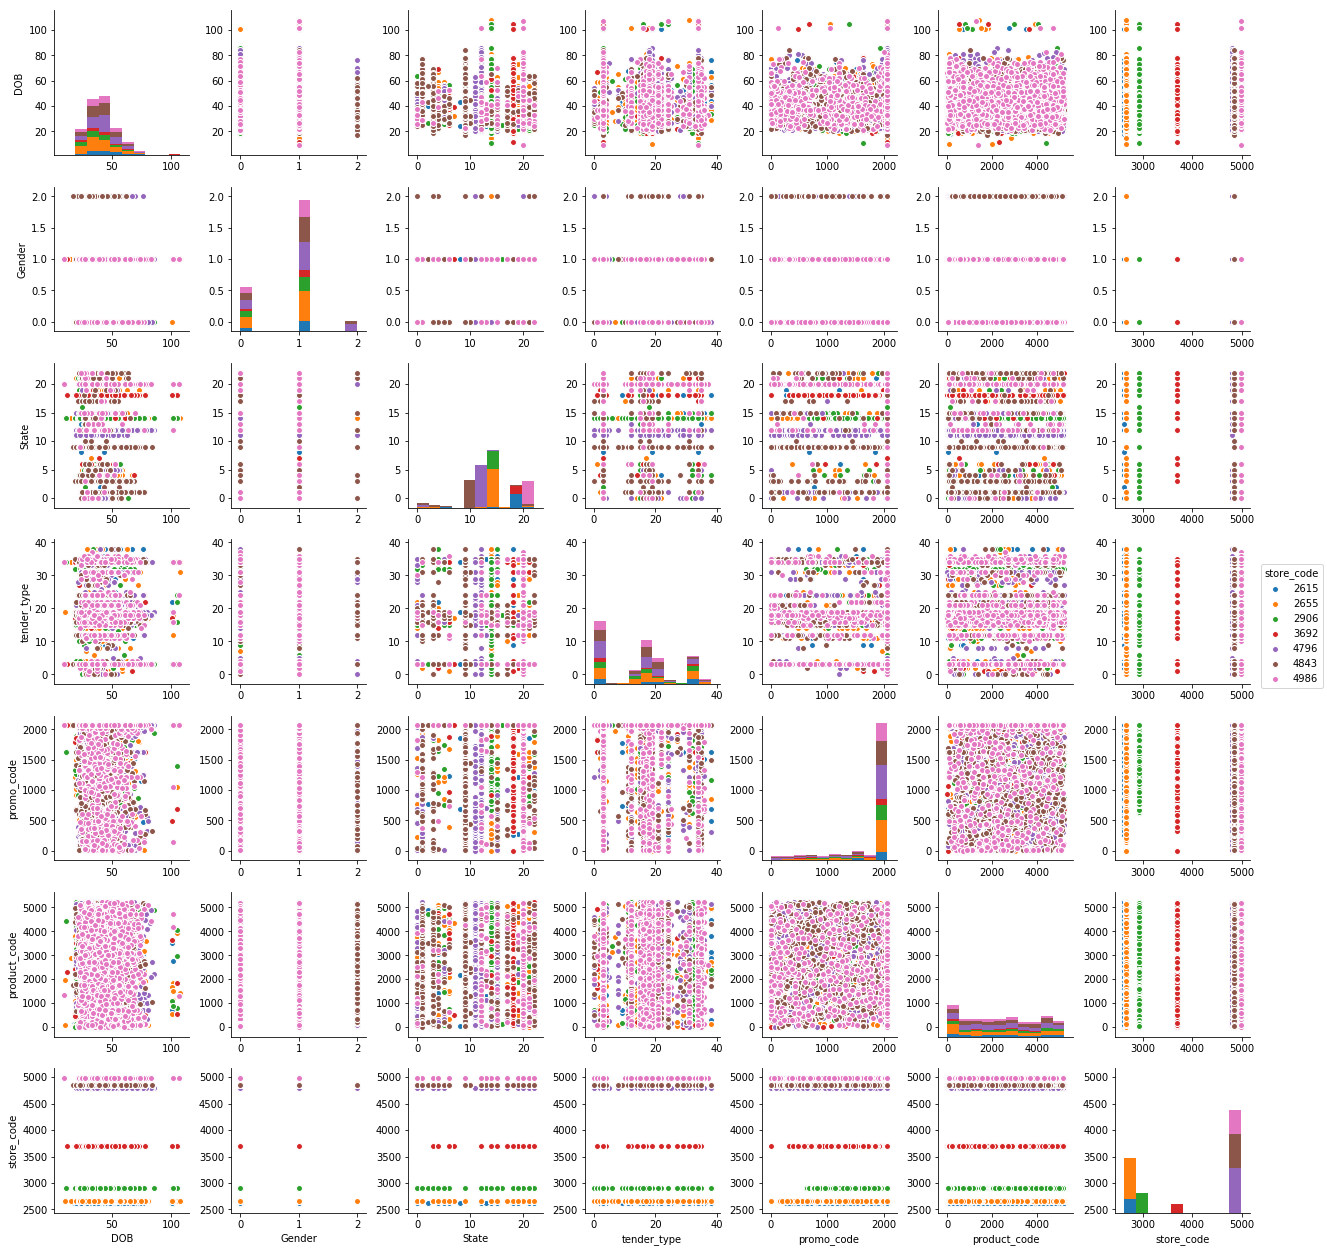

In [39]:
cols=['DOB','Gender','State','tender_type','promo_code','product_code','store_code']
plt.figure()
sns.pairplot(df[cols],hue='store_code')
plt.show()

Histograms


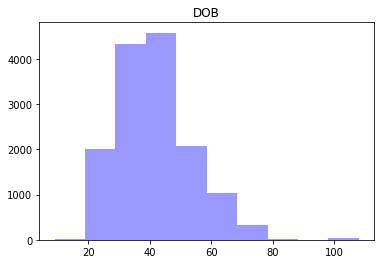

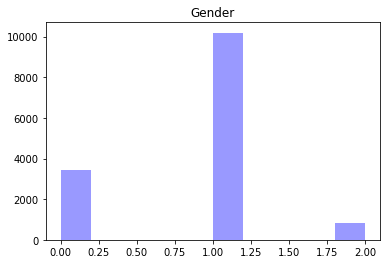

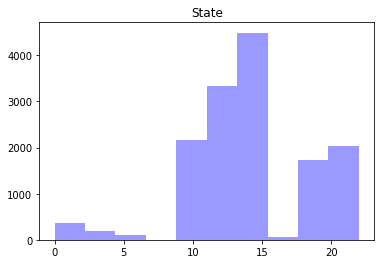

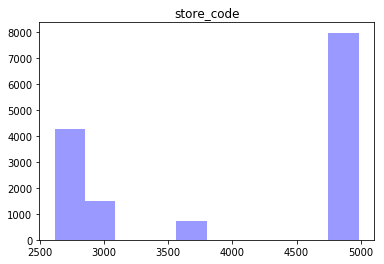

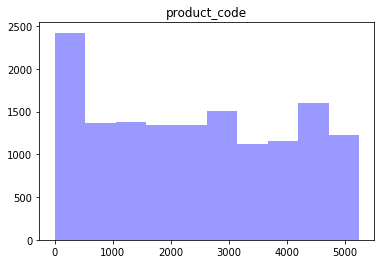

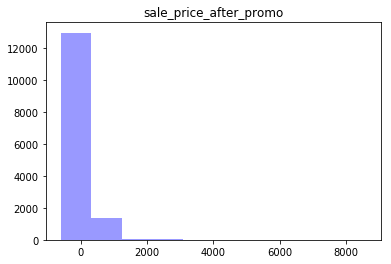

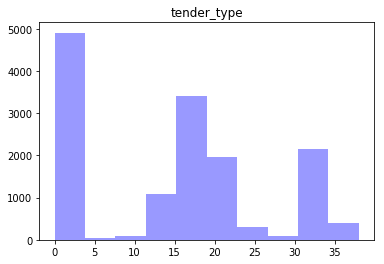

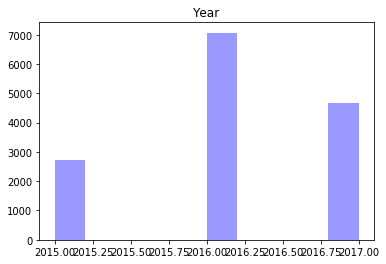

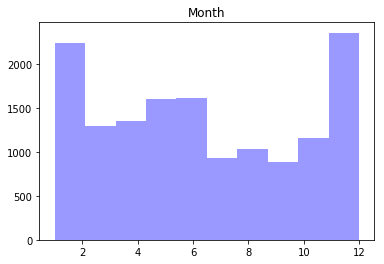

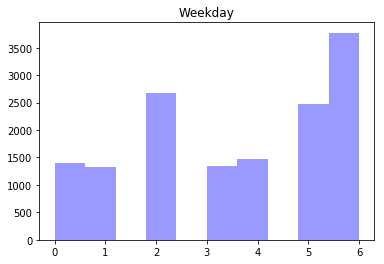

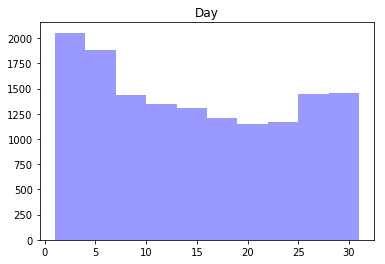

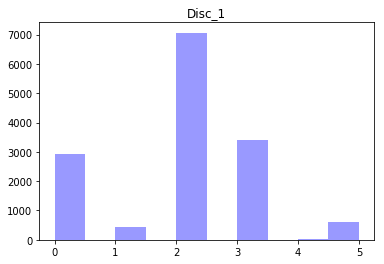

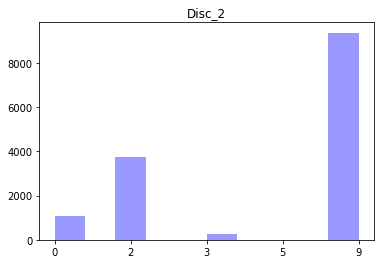

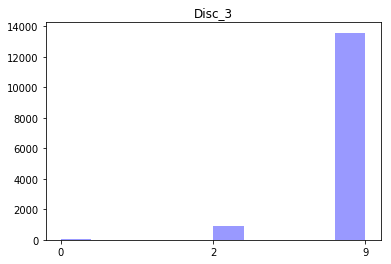

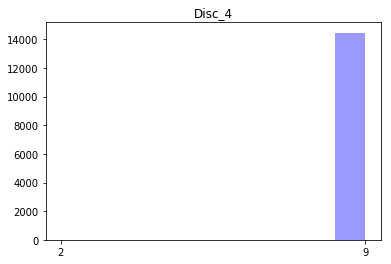

In [40]:
# histograms
# plot histograms
colNames = df.columns.tolist()
colNames.remove('customerID')
#colNames.remove('DOB')                           
#colNames.remove('Gender')
#colNames.remove('State')
colNames.remove('transaction_number_by_till')    
colNames.remove('promo_code')                    
#colNames.remove('product_code')                  
#colNames.remove('sale_price_after_promo')
#colNames.remove('discountUsed')
#colNames.remove('tender_type')                
colNames.remove('payment_amount_by_tender')
#colNames.remove('Year')    
#colNames.remove('Month')                        
#colNames.remove('Weekday')                       
#colNames.remove('Day')
                
print('Histograms')
for colName in colNames:
    colValues = df[colName].values
    plt.figure();
    sns.distplot(colValues, bins=10, kde=False, color='b')
    plt.title(colName)
    plt.show()

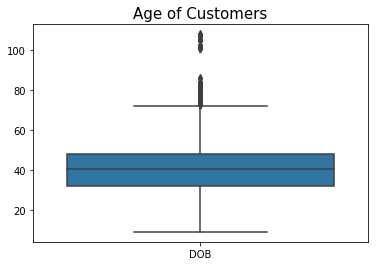

In [41]:
# boxplot
cols1=['DOB','customerID']
plt.figure()
sns.boxplot(data=df[cols1])
plt.title("Age of Customers", fontsize=15)
plt.show()

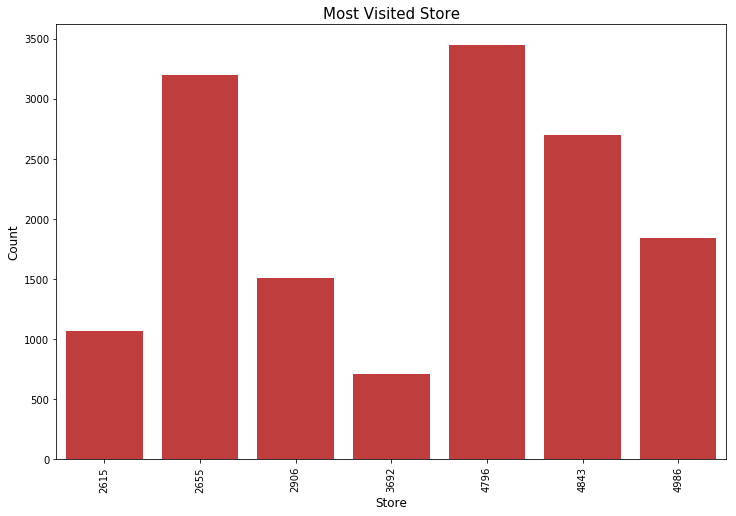

In [42]:
plt.figure(figsize=(12,8))
sns.countplot(x="store_code", data=df, color=color[3])
plt.ylabel("Count", fontsize=12)
plt.xlabel("Store", fontsize=12)
plt.xticks(rotation="vertical")
plt.title("Most Visited Store", fontsize=15)
plt.show()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14466 entries, 0 to 14465
Data columns (total 19 columns):
customerID                    14466 non-null object
DOB                           14466 non-null int64
Gender                        14466 non-null int64
State                         14466 non-null int64
store_code                    14466 non-null int64
transaction_number_by_till    14466 non-null int64
promo_code                    14466 non-null int64
product_code                  14466 non-null int64
sale_price_after_promo        14466 non-null float64
tender_type                   14466 non-null int64
payment_amount_by_tender      14466 non-null float64
Year                          14466 non-null int64
Month                         14466 non-null int64
Weekday                       14466 non-null int64
Day                           14466 non-null int64
Disc_1                        14466 non-null int64
Disc_2                        14466 non-null object
Disc_3            

In [44]:
#colNames = ['DOB', 'Gender','State','transaction_number_by_till','promo_code','product_code','sale_price_after_promo','discountUsed','tender_type','payment_amount_by_tender','Year', 'Month', 'Weekday', 'Day']
colNames = ['DOB', 'Gender','promo_code','product_code','tender_type','Disc_1','Disc_2','Disc_3','Disc_4']
X = df[colNames].values
#X = df.loc[:, colNames].values
y = df['store_code'].values
#y = df.loc[:,['store_code']].values

In [45]:
# shape
print(X.shape)
print(y.shape)

(14466, 9)
(14466,)


In [46]:
# head
print(X[0:4])
print(y[0:4])

[[42 1 2068 3197 19 2 '9' '9' '9']
 [36 0 211 3386 3 2 '9' '9' '9']
 [31 1 2068 3035 29 2 '9' '9' '9']
 [29 1 220 4606 3 2 '9' '9' '9']]
[2655 2655 2615 2655]


In [47]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, random_state=707)

# dispaly 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9692, 9)
(9692,)
(4774, 9)
(4774,)


In [48]:
rbs = RobustScaler()
cld2 = rbs.fit_transform(X_train)

In [49]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(cld2)
principalDf = pd.DataFrame(data = principalComponents,columns = ['principal component 1', 'principal component 2'])

In [50]:
df2= pd.DataFrame(data=y_train,columns = ["Store_Code"])

In [51]:
finalDf = pd.concat([principalDf, df2], axis = 1)

In [52]:
finalDf.head()

,principal component 1,principal component 2,Store_Code
0,6.524730,-1.524953,4843
1,-0.594719,-0.760064,4986
2,-0.493923,-0.770082,4796
3,-1.076608,-0.829355,4796
4,-0.557099,-0.759042,4986


In [53]:
#df['store_code'].unique()

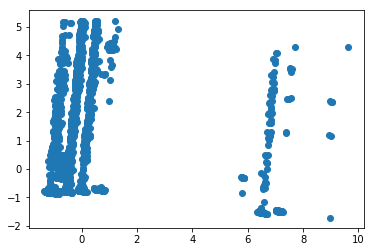

In [54]:
import matplotlib.pyplot
matplotlib.pyplot.scatter(principalDf.head(4500)['principal component 1'],principalDf.head(4500)['principal component 2'])
plt.show()

In [55]:
finalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9692 entries, 0 to 9691
Data columns (total 3 columns):
principal component 1    9692 non-null float64
principal component 2    9692 non-null float64
Store_Code               9692 non-null int64
dtypes: float64(2), int64(1)
memory usage: 227.2 KB


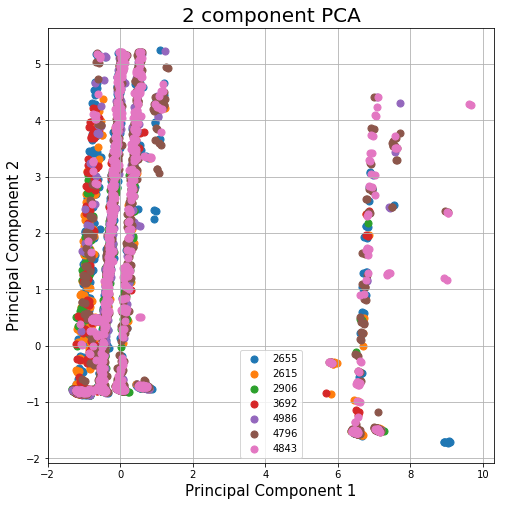

In [56]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [2655, 2615, 2906, 3692, 4986, 4796, 4843]
colors = sns.color_palette()
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Store_Code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

In [57]:
pca.explained_variance_ratio_

array([ 0.36653829,  0.28448314])

In [58]:
# k means cluster
km1 = KMeans(n_clusters=3)
km2 = km1.fit(principalComponents)

In [59]:
rbs = RobustScaler()
cld3 = rbs.fit_transform(X_test)

In [60]:
#pca = PCA(n_components=2)
cld3 = pca.fit_transform(cld3)

In [61]:
#train the data
label = km2.predict(cld3)
silhouette_score(cld3, label)

0.77112599640685608

In [62]:
colNames_1 = ['DOB', 'Gender','promo_code','product_code','tender_type','Disc_1','Disc_2','Disc_3','Disc_4']
X_1 = df[colNames_1].values
#X = df.loc[:, colNames].values
y_1 = df['store_code'].values
#y = df.loc[:,['store_code']].values

In [63]:
rbs_1 = RobustScaler()
cld2_1 = rbs_1.fit_transform(X_1)

In [64]:
pca_1 = PCA(n_components=2)
principalComponents_1 = pca_1.fit_transform(cld2_1)
principalDf_1 = pd.DataFrame(data = principalComponents_1,columns = ['principal component 1', 'principal component 2'])

In [65]:
df3= pd.DataFrame(data=y_1,columns = ["Store_Code"])

In [66]:
finalDf_1 = pd.concat([principalDf_1, df3], axis = 1)

In [67]:
finalDf_1.head()

,principal component 1,principal component 2,Store_Code
0,-0.561337,-0.774623,2655
1,0.358358,4.936447,2655
2,-0.571444,-0.778990,2615
3,0.360917,4.921304,2655
4,-0.084475,1.982580,2906


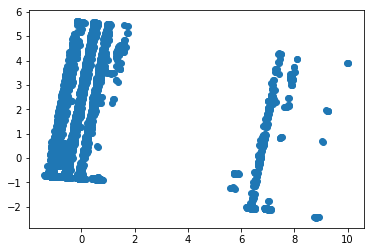

In [68]:
matplotlib.pyplot.scatter(principalDf_1.head(14466)['principal component 1'],principalDf_1.head(14466)['principal component 2'])
plt.show()

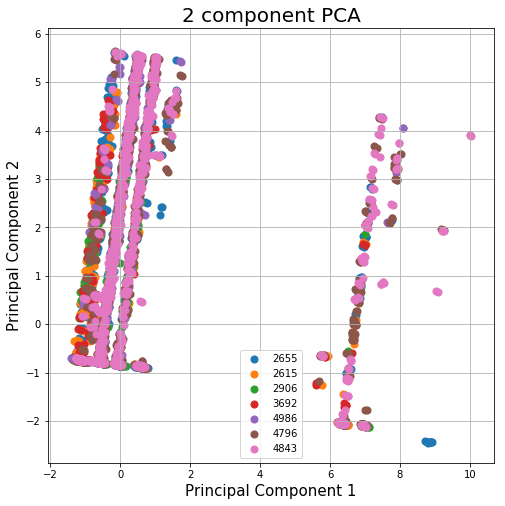

In [69]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [2655, 2615, 2906, 3692, 4986, 4796, 4843]
colors = sns.color_palette()
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_1['Store_Code'] == target
    ax.scatter(finalDf_1.loc[indicesToKeep, 'principal component 1']
               , finalDf_1.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

In [70]:
pca.explained_variance_ratio_

array([ 0.40814162,  0.30025585])

In [71]:
km1 = KMeans(n_clusters=3)
km2 = km1.fit(principalComponents_1)
cld2_1 = rbs.fit_transform(X_1)
cld4 = pca.fit_transform(cld2_1)
label = km2.predict(cld4)
silhouette_score(cld4, label)

0.77522885629633143

In [72]:
customers=df["customerID"]
store=df["store_code"]

In [73]:
sub1 = pd.DataFrame({'customerID':customers, 'store_code':store, 'cluster':label},)

In [74]:
cols=['customerID','store_code','cluster']

In [75]:
sub1=sub1[cols]

In [76]:
#np.savetxt('./data/subText.txt', cld2_1)
sub1.to_csv('./data/predictedCluster.csv', index=False)